# Downloading data (Only first)

In [1]:
!pip install kagglehub

In [2]:
import kagglehub
import os 

if not os.path.exists("./data"):
    os.makedirs("./data")

# Download latest version
path = kagglehub.dataset_download("jaafaryassine/painter-by-numbers")

print("Path to dataset files:", path)

100%|██████████| 2.24G/2.24G [04:53<00:00, 8.21MB/s]

Extracting files...


Path to dataset files: C:\Users\hjjan\.cache\kagglehub\datasets\jaafaryassine\painter-by-numbers\versions\1


In [ ]:
!mv {path}/* './data'

�ߺ��Ǵ� ���� �̸��� �ְų� ������
ã�� �� �����ϴ�.


# Data load by pandas dataframe

In [1]:
import pandas as pd
import numpy as np
csv_file='./data/imagesinfo.csv'

data=pd.read_csv(csv_file)

/opt/conda/lib/python3.8/site-packages/pandas/compat/_optional.py:161: UserWarning: Pandas requires version '2.7.1' or newer of 'numexpr' (version '2.7.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
data

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,836.jpg
...,...,...,...,...,...,...,...,...,...,...
103245,Jackson Pollock,1948.0,abstract,682.0,220.0,96405.0,wikiart,Action painting,Number 13A (Arabesque),25525.jpg
103246,Bernardo Strozzi,NaN,religious painting,329.0,456.0,127594.0,wikiart,Baroque,St. Francis of Assisi,47038.jpg
103247,Josef Sima,NaN,landscape,293.0,512.0,102519.0,wikiart,Surrealism,Maisons à la campagne II,7680.jpg
103248,Brett Whiteley,1982.0,marina,293.0,512.0,167423.0,wikiart,NaN,Thebe's Revenge,9021.jpg


In [2]:
image_path='./data/images/'+data['filename'].values
artist_name=data['artist'].values
style_name=data['style'].values
title=data['title'].values

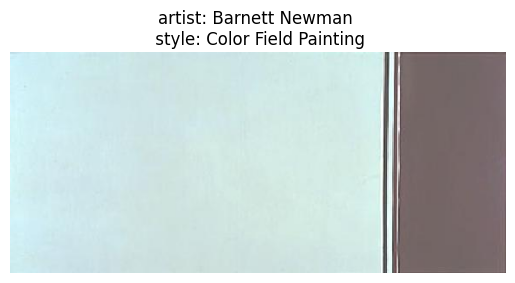

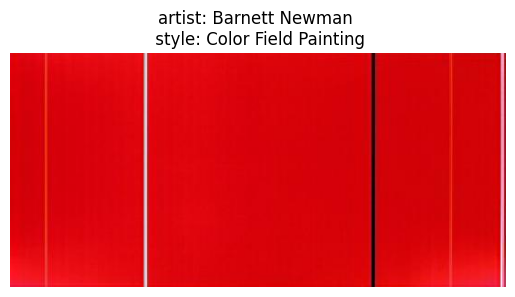

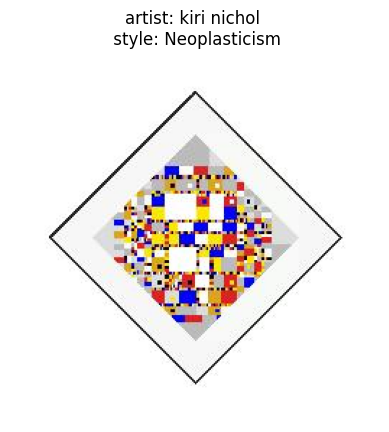

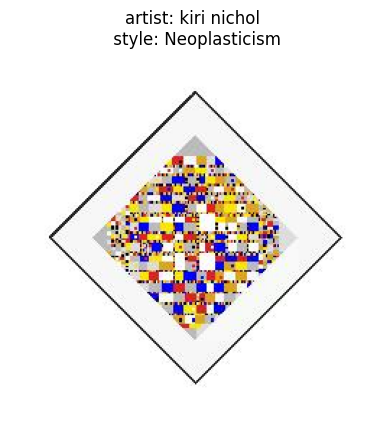

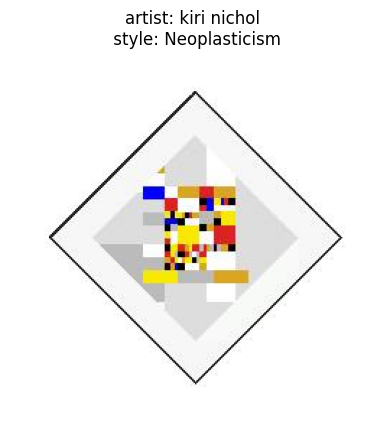

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(5):
    plt.title(f"artist: {artist_name[i]} \n style: {style_name[i]}")
    plt.imshow(mpimg.imread(image_path[i]))
    plt.axis('off')
    plt.show()

# Image into Loading dataset

Example sample number = `100`\
It should be lower than `103250`

Image shape will `(sample number, 3, 256, 256)`

`x`: image dataset

`y`: style label

`z`: title label 

`w`: artist label

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from PIL import Image


transform=transforms.Compose([
    transforms.Resize((256,256)),
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: x/ 255.0),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
class StyleLabelMapper:
    def __init__(self, label_encoder):
        self.label_encoder = label_encoder

    def get_style_name(self, encoded_label):
        return self.label_encoder.inverse_transform([encoded_label])[0]

    def get_all_style_names(self):
        return self.label_encoder.classes_

In [ ]:
from sklearn.preprocessing import LabelEncoder
import torchvision.io as io
# Encode the style names into integers
style_encoder = LabelEncoder()
title_encoder = LabelEncoder()
artist_encoder = LabelEncoder()
style_mapper = StyleLabelMapper(style_encoder)
title_mapper = StyleLabelMapper(title_encoder)
artist_mapper = StyleLabelMapper(artist_encoder)

# Number of samples should be lower than 103250
num_sample=3000
# 1000 samples require 27 seconds in 6000 Mhz ram
# 10000 samples require over 6000 seconds in 6000 Mhz ram

style_name_encoded = style_encoder.fit_transform(style_name[:num_sample])
title_encoded = title_encoder.fit_transform(title[:num_sample])
artist_encoded = artist_encoder.fit_transform(artist_name[:num_sample])

img_all = torch.empty((0, 3, 256, 256)).to(device)
for i in range(len(image_path[:num_sample])):
    img_tmp = io.read_image(image_path[i])
    # Apply the transform to the image
    img_tmp = transform(img_tmp)
    img_all=torch.cat((img_all, img_tmp.unsqueeze(0)), 0) if i > 0 else img_tmp.unsqueeze(0)

# Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(img_all, style_name_encoded, test_size=0.2, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
z_train, z_test, w_train, w_test = train_test_split(title_encoded, artist_encoded, test_size=0.2, random_state=42)

# Convert the labels to tensors
y_train = torch.tensor(y_train, dtype=torch.long)
y_valid = torch.tensor(y_valid, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

print("All styles:", len(style_mapper.get_all_style_names()))
print("All artists numbers:", len(artist_mapper.get_all_style_names()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6..1.3921568].


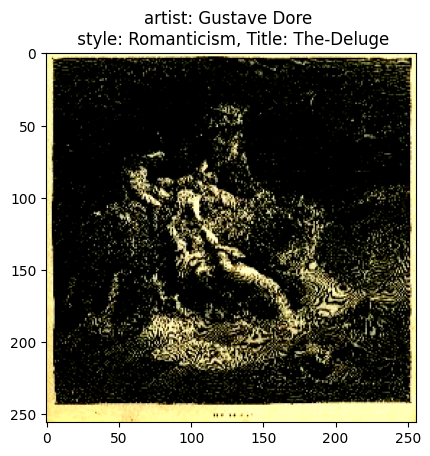

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6..1.2745098].


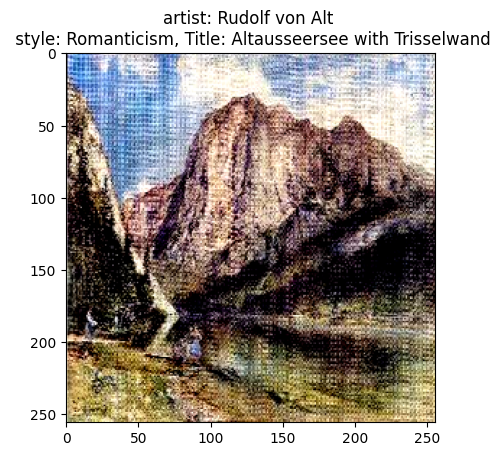

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6..1.3921568].


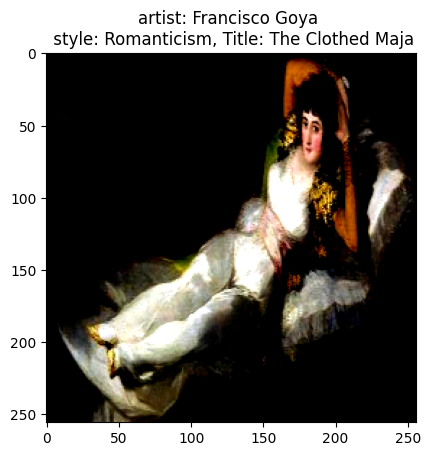

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6..1.3921568].


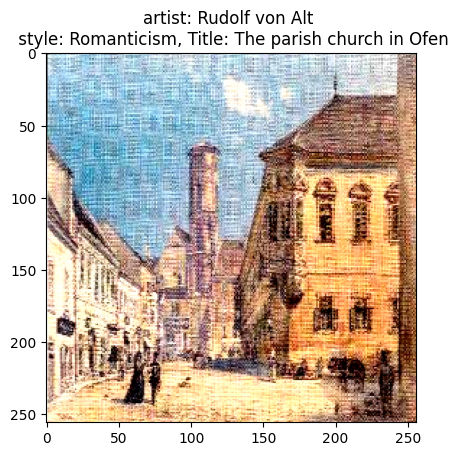

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6..1.4].


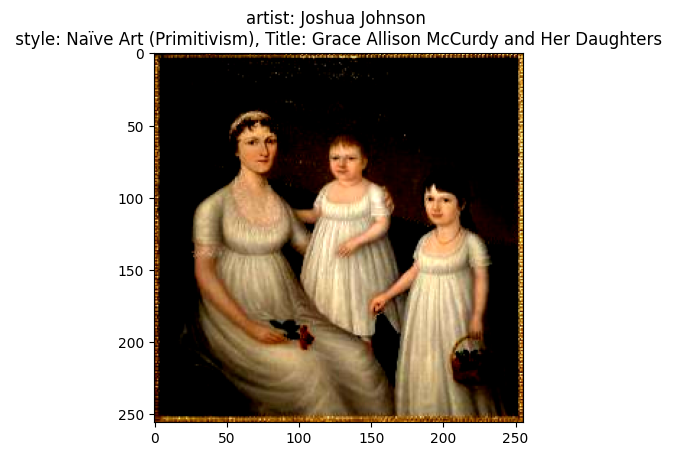

In [87]:
# np.shape(x_train)
for i in range(5):
    plt.imshow(x_train[i].permute(1, 2, 0))
    plt.title(f"artist: {artist_mapper.get_style_name(w_train[i])} \n style: {style_mapper.get_style_name(y_train[i].item())}, Title: {title_mapper.get_style_name(z_train[i])}")
    plt.show()

In [8]:
train_set=torch.utils.data.TensorDataset(x_train, y_train)
train_loader=torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

valid_set=torch.utils.data.TensorDataset(x_valid, y_valid)
valid_loader=torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

test_set=torch.utils.data.TensorDataset(x_test, y_test)
test_loader=torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

Data loader shape: \
(data len, 2, ...)

if take image section: \
`(data len, 0, 3,256,256)`

elif take label section: \
`(data len, 1, )`

# Define CNN architecture 

In [10]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


## Base model CNN architecture 

3 Convolution layers. 

kernel number will be 32 -> 64 -> 128

In [9]:
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*64*64, 1024)
        self.fc2 = nn.Linear(1024, len(style_mapper.get_all_style_names()))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B, 32, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))  # (B, 64, 7, 7)
        x = x.view(-1, 64*64*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
model= BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=1e-5)

## Triple CNN architecture

In [19]:
class CNN_trip(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2, padding=0)
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(1024 * 16 * 16, 1024)  # Updated input size
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, len(style_mapper.get_all_style_names()))

    def forward(self, x):
        x = self.conv2(self.conv1(x))
        x = self.pool(F.relu(x))
        x = self.dropout(x)
        x = self.conv4(self.conv3(x))
        x = self.pool(F.relu(x))
        x = self.dropout(x)
        # x= self.conv6(self.conv5(x))
        x=self.pool(F.relu(self.conv5(x)))
        x = self.dropout(x)
        x= self.conv6(x)
        x = self.pool(F.relu(x))
        x = self.dropout(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x= self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [20]:
model= CNN_trip().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=1e-5)

# Train section

In [21]:
import tqdm

def training(train_loader, val_loader,test_loader, model, criterion, optimizer, num_epochs, device, 
                 save_path=None, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    # 각 epoch별 loss를 저장할 리스트
    train_loss_history = []
    val_loss_history = []
    test_accuracy_history = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        # with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training", leave=False) as tbar:
        with tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training", leave=False) as tbar:
            for images, labels in tbar:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                tbar.set_postfix(loss=loss.item())
        # epoch마다 평균 train loss 계산
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            with tqdm.tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation", leave=False) as vbar:
                for images, labels in vbar:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    vbar.set_postfix(val_loss=loss.item())
        
        # epoch마다 평균 validation loss 계산
        val_loss /= len(val_loader)
        
        # 리스트에 loss 기록
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        # best model 저장 및 early stopping 처리
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if save_path:
                torch.save(model.state_dict(), save_path)
                print(f"Best model saved with validation loss: {best_val_loss:.4f}")
            epochs_no_improve = 0  # 개선 시 카운터 리셋
        else:
            epochs_no_improve += 1

        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        test_accuracy_history.append(accuracy)
        print(f"Accuracy of the network on the test images: {accuracy:.2f}%")
        
        if epochs_no_improve == patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
    
    return train_loss_history, val_loss_history, test_accuracy_history

In [22]:
train_loss, val_loss, test_accur=training(train_loader, valid_loader, test_loader, model, criterion, optimizer, num_epochs=30, device=device, save_path='../weights/best_model_1000.pth', patience=5)

Best model saved with validation loss: 3.4288
Epoch 1/30, Training Loss: 3.8001, Validation Loss: 3.4288
Accuracy of the network on the test images: 12.00%


Best model saved with validation loss: 3.2571
Epoch 2/30, Training Loss: 3.4206, Validation Loss: 3.2571
Accuracy of the network on the test images: 12.00%


Best model saved with validation loss: 3.2109
Epoch 3/30, Training Loss: 3.3273, Validation Loss: 3.2109
Accuracy of the network on the test images: 14.00%


Best model saved with validation loss: 3.1905
Epoch 4/30, Training Loss: 3.2401, Validation Loss: 3.1905
Accuracy of the network on the test images: 12.00%


Best model saved with validation loss: 3.1683
Epoch 5/30, Training Loss: 3.2101, Validation Loss: 3.1683
Accuracy of the network on the test images: 18.00%


Best model saved with validation loss: 3.1601
Epoch 6/30, Training Loss: 3.1947, Validation Loss: 3.1601
Accuracy of the network on the test images: 12.00%


Best model saved with validation loss: 3.0855
Epoch 7/30, Training Loss: 3.1601, Validation Loss: 3.0855
Accuracy of the network on the test images: 16.00%


Best model saved with validation loss: 3.0375
Epoch 8/30, Training Loss: 3.1594, Validation Loss: 3.0375
Accuracy of the network on the test images: 13.00%


Best model saved with validation loss: 3.0329
Epoch 9/30, Training Loss: 3.1445, Validation Loss: 3.0329
Accuracy of the network on the test images: 16.00%


Best model saved with validation loss: 2.9523
Epoch 10/30, Training Loss: 3.1187, Validation Loss: 2.9523
Accuracy of the network on the test images: 21.00%


Epoch 11/30, Training Loss: 3.0640, Validation Loss: 2.9704
Accuracy of the network on the test images: 22.00%


Best model saved with validation loss: 2.8098
Epoch 12/30, Training Loss: 2.9831, Validation Loss: 2.8098
Accuracy of the network on the test images: 22.00%


Best model saved with validation loss: 2.7828
Epoch 13/30, Training Loss: 2.9166, Validation Loss: 2.7828
Accuracy of the network on the test images: 25.00%


Best model saved with validation loss: 2.7350
Epoch 14/30, Training Loss: 2.8660, Validation Loss: 2.7350
Accuracy of the network on the test images: 23.00%


Best model saved with validation loss: 2.7011
Epoch 15/30, Training Loss: 2.8259, Validation Loss: 2.7011
Accuracy of the network on the test images: 25.00%


Best model saved with validation loss: 2.5606
Epoch 16/30, Training Loss: 2.7641, Validation Loss: 2.5606
Accuracy of the network on the test images: 28.00%


Best model saved with validation loss: 2.5277
Epoch 17/30, Training Loss: 2.7113, Validation Loss: 2.5277
Accuracy of the network on the test images: 29.00%


Best model saved with validation loss: 2.4032
Epoch 18/30, Training Loss: 2.6392, Validation Loss: 2.4032
Accuracy of the network on the test images: 27.00%


Epoch 19/30, Training Loss: 2.5795, Validation Loss: 2.4237
Accuracy of the network on the test images: 29.00%


Best model saved with validation loss: 2.3388
Epoch 20/30, Training Loss: 2.5275, Validation Loss: 2.3388
Accuracy of the network on the test images: 29.00%


Best model saved with validation loss: 2.3361
Epoch 21/30, Training Loss: 2.5068, Validation Loss: 2.3361
Accuracy of the network on the test images: 29.00%


Best model saved with validation loss: 2.3257
Epoch 22/30, Training Loss: 2.4904, Validation Loss: 2.3257
Accuracy of the network on the test images: 29.00%


Best model saved with validation loss: 2.2855
Epoch 23/30, Training Loss: 2.4879, Validation Loss: 2.2855
Accuracy of the network on the test images: 29.00%


Epoch 24/30, Training Loss: 2.4597, Validation Loss: 2.2870
Accuracy of the network on the test images: 29.00%


Best model saved with validation loss: 2.2576
Epoch 25/30, Training Loss: 2.4117, Validation Loss: 2.2576
Accuracy of the network on the test images: 29.00%


Epoch 26/30, Training Loss: 2.4299, Validation Loss: 2.2672
Accuracy of the network on the test images: 31.00%


Epoch 27/30, Training Loss: 2.3616, Validation Loss: 2.2782
Accuracy of the network on the test images: 33.00%


Best model saved with validation loss: 2.2346
Epoch 28/30, Training Loss: 2.3397, Validation Loss: 2.2346
Accuracy of the network on the test images: 34.00%


Best model saved with validation loss: 2.1802
Epoch 29/30, Training Loss: 2.2931, Validation Loss: 2.1802
Accuracy of the network on the test images: 30.00%


Epoch 30/30, Training Loss: 2.3369, Validation Loss: 2.2325
Accuracy of the network on the test images: 30.00%
